# Medical Report Generation Case Study

### [1.0] Business Problem
- Medical images are widely used in clinical decision making. For example, chest x-ray images are used for diagnosing pneunomia and pleutral effusion.
- The interpretaion of medical images requires extensive expertise and are prone to human errors. Considering the demands of accurately interpreting medical images in large amounts within short times, an automatic medical report generation model can be very useful.

### [1.1] Problem Statement
For a given chest X-ray image we need to generate medical conclusive report for helping the doctors in understanding and proceeding with further treatments.

### [1.2] References
- http://academictorrents.com/details/66450ba52ba3f83fbf82ef9c91f2bde0e845aba9
- http://academictorrents.com/details/5a3a439df24931f410fac269b87b050203d9467d  
- https://medium.com/@Petuum/on-the-automatic-generation-of-medical-imaging-reports-7d0a7748fe3d
- https://mc.ai/medical-report-generation-using-deep-learning/
- https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/
- https://guillaumegenthial.github.io/sequence-to-sequence.html
- https://guillaumegenthial.github.io/image-to-latex.html
- https://arxiv.org/pdf/1711.08195.pdf
- https://arxiv.org/pdf/1409.0473.pdf

### [2.0] Data Overview
- The data is in two different folders, one contains only images and another contain reports.
- Reports data is stored in XML file and total size of data stored in XML format is 30.1 MB
- Total number of reports are 3955
- Total size of images data is 1.28 GB
- Total number of images are 7470

### [2.1] Data Field Explanation
- COMPARISON: Information about the type of chest view
- INDICATION: These field basically explains the type of disease in the patient
- FINDINGS: These field explains in detail about the indication and the chest x-ray image
- IMPRESSION: These concludes are report stating whether report is normal or not
- image_id: ID associated with each x-ray image

### Performance Metric:
- BLEU(Bilingual Evaluation Understudy)
- BLEU is an evaluation metric initially  proposed for machine translation  and defined as a geometric mean of  n-gram precision scores multiplied by a brevity penalty for short  sentences. 

In [1]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
#tf.enable_eager_execution()
tf.executing_eagerly() 

False

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1250955273657913854
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3141979340
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14083132538288371030
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)
print(device)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import re
import xml.etree.ElementTree as ET
import random
import os, argparse
import cv2, spacy, numpy as np
from os import path 
from tensorflow.keras.models import load_model
from tensorflow.keras import Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from pickle import load
from tqdm import tqdm
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import model_from_json
from tensorflow.keras.optimizers import SGD
from sklearn.externals import joblib
from nltk.translate.bleu_score import corpus_bleu
#from keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
import csv
import numpy as np
import pandas as pd
import os
import xmltodict
from xml.dom import minidom
#K.set_image_data_format('channels_first')

### [2.2] Example Data Point

In [8]:
# Reference : https://www.guru99.com/manipulating-xml-with-python.html
# YouTube : https://www.youtube.com/watch?v=DejHQYAGb7Q
# https://docs.python.org/3.4/library/xml.etree.elementtree.html
import xml.etree.ElementTree as ET
col_list = list()
file = 'G:/Self Case Study II/NLMCXR_reports/ecgen-radiology/1200.xml'
tree = ET.parse(file)
root = tree.getroot()
for child in root:
    if child.tag == 'MedlineCitation':
        for attr in child:
            if attr.tag == 'Article':
                for i in attr:
                    if i.tag == 'Abstract':
                        for name in i:
                            if name.get('Label') == 'COMPARISON':
                                comparison = name.text
                            elif name.get('Label') == 'INDICATION':
                                indication = name.text
                            elif name.get('Label') == 'FINDINGS':
                                findings = name.text
                            elif name.get('Label') == 'IMPRESSION':
                                impression = name.text
        for p_image in root.findall('parentImage'):
            idd = p_image.get('id')
            print('\nComparison: ',comparison)
            print('\nIndication: ',indication)
            print('\nFindings: ',findings)
            print('\nImpression: ',impression)
            print('\nID: ',idd)
            break


Comparison:  None

Indication:  XXXX, smoking.

Findings:  The heart is not enlarged. The central pulmonary vasculature is not engorged. Visualized osseous structures are unremarkable. No pneumothorax or pleural effusion. Small right juxtahilar opacity may represent infiltrate. Lungs are otherwise well aerated.

Impression:  Small right juxtahilar opacity may represent infiltrate in the setting of XXXX. Followup chest x-XXXX is recommended at an appropriate interval following treatment to document XXXX.

ID:  CXR1200_IM-0134-1001


### [3.0] EDA

### [3.1] Total number of images

In [6]:
directory = 'G:/Self Case Study II/NLMCXR_png'
total_images = os.listdir(directory)
print('Total number of images: ',len(total_images))

Total number of images:  7470


In [4]:
count=0
print("Name of the X-ray file:")
for name in os.listdir(directory): 
    if count==3:
        break
    image_id = name.split('.')[0] 
    print('\n',image_id)
    count += 1

Name of the X-ray file:

 CXR1000_IM-0003-1001

 CXR1000_IM-0003-2001

 CXR1000_IM-0003-3001


In [5]:
##Getting size of images
directory = 'G:/Self Case Study II/NLMCXR_png'
list_of_heights = []
list_of_widths = []
#for i in os.listdir(directory):
for image in os.listdir(directory):
    img = cv2.imread(directory + '/'+ image)
        # get dimensions of image
    shape = img.shape
    list_of_heights.append(shape[0])
    list_of_widths.append(shape[1])

Text(0.5, 1.0, 'heights')

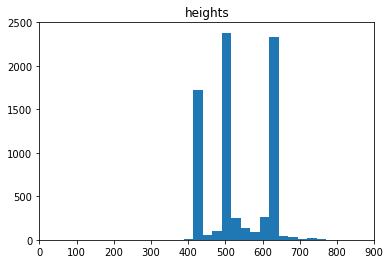

In [6]:
##plotting 
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(list_of_heights,bins=20)
plt.xlim(0,900)
plt.title('heights')

In [7]:
np.median(list_of_heights)

512.0

In [8]:
np.mean(list_of_heights)

532.7789825970549

In [9]:
np.median(list_of_widths)

512.0

In [10]:
np.mean(list_of_widths)

512.0

### [3.2] Total number of reports

In [5]:
directory = 'G:/Self Case Study II/NLMCXR_reports/ecgen-radiology'
total_reports = os.listdir(directory)
print('Total number of reports: ',len(total_reports))

Total number of reports:  3955


In [6]:
count=0
print("Name of the XML file:")
for name in os.listdir(directory): 
    if count==10:
        break
    report_id = name.split('.')[0] 
    print(report_id)
    count += 1

Name of the XML file:
1
10
100
1000
1001
1002
1003
1004
1005
1006


- If we notice the report file names are following table of ten and after 1000, they are following regular number

In [7]:
import cv2
import numpy as np

# Load image, create mask, grayscale, Gaussian blur, Otsu's threshold
image = cv2.imread('G:/Self Case Study II/NLMCXR_png/CXR1000_IM-0003-1001.png')
cv2.imshow

<function imshow>

#### In the step below we are performing data augmentation on our image data

In [6]:
datagen = ImageDataGenerator(
        rotation_range = 15,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True )

## Loading Image features from saved pickle file

In [7]:
from pickle import dump
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model

In [8]:
from tensorflow.keras.models import load_model 
from pickle import load
filename = 'features_concat.pkl'
features = load(open(filename, 'rb'))

In [9]:
print('After loading saved features pickle file:')
print('\nTotal number of images: ',len(features))
print('Vector size of extracted feature: ', len(features['CXR1000_IM-0003-3001'][0]))

After loading saved features pickle file:

Total number of images:  22410
Vector size of extracted feature:  4096


### Loading Text data

In [10]:
from tqdm import tqdm
from os import path 
id_imp = dict()
id_find = dict()
directory = 'G:/Self Case Study II/NLMCXR_reports/ecgen-radiology'

for fname in tqdm(os.listdir(directory)):
    if fname.endswith('.xml'):
        f = path.join(directory,fname)
        tree = ET.parse(f)
        root = tree.getroot()
        for child in root:
            if child.tag == 'MedlineCitation':
                for attr in child:
                    if attr.tag == 'Article':
                        for i in attr:
                            if i.tag == 'Abstract':
                                for name in i:
                                    if name.get('Label') =='FINDINGS':
                                        finding = name.text
                                    elif name.get('Label') == 'IMPRESSION':
                                        impression = name.text
        
        for p_image in root.findall('parentImage'):
            idd = p_image.get('id')
            id_imp[idd] = impression
            id_find[idd] = finding
            for i in range(1,3):
                id_ = idd + str(i)
                id_imp[id_] = impression
                id_find[id_] = finding

100%|████████████████████████████████████████████████████████████████████████████| 3955/3955 [00:01<00:00, 3887.71it/s]


### Data Cleaning

In [11]:
cnt = 0
# In this step we are basically counting the total number of None values
for k,v in id_imp.items():
    if id_imp[k] is None:
        cnt += 1
print('Total count of None values are: ',cnt)

Total count of None values are:  156


In [12]:
cnt = 0

for k,v in id_find.items():
    if id_find[k] is None:
        cnt += 1
print('Total count of none values in finding: ',cnt)

Total count of none values in finding:  2991


In [13]:
cnt = 0

for k,v in id_imp.items():
    if (id_find[k]) and (id_imp[k]) is None:
        cnt += 1
print('Total count of None values in findings and impression are: ',cnt)

Total count of None values in findings and impression are:  36


In [14]:
cnt = 0

for k,v in id_find.items():
    if (id_find[k]) or (id_imp[k]) is None:
        cnt += 1
print('Total count of None values in findings or impression are: ',cnt)

Total count of None values in findings or impression are:  19539


- In the code snippet above we are trying to count the total number None values either in findings or impressions of text data
- Total number of None values in findings or impressions are 19539
- We delete the findings and impressions with None values in the next step

### Delete None values

In [15]:
id_imp_none_rem = dict()
cnt = 0
cnt1 = 156

for k,v in id_imp.items():
    if v is not None:
        cnt += 1
        id_imp_none_rem[k] = v
print('Total number of none values',str(len(id_imp))+ ' - '+ str(cnt1) +' = '+str(cnt) )

Total number of none values 22410 - 156 = 22254


- Now we will remove the None values from findings and impressions
- We are storing our impressions without None values in a dictionary variable called id_imp_none_rem

In [16]:
cnt = 0

finding_none_values = dict()

for k,v in id_find.items():
    if (id_imp[k] is None) or (id_find[k] is None):
        cnt += 1
        continue
    else:
        finding_none_values[k] = v
print('Total none values in findings and impressions are: ',cnt)
print('Number of final findings without None values are: ',str(len(finding_none_values)))

Total none values in findings and impressions are:  3027
Number of final findings without None values are:  19383


- We removed None values from impressions and now we do the same for findings
- we store our final findings without None values in a dictionary variable called finding_none_values.

## [4.0] Text Preprocessing

In [17]:
import re
def clean_desc(desc,add_token):
    '''Function for cleaning the description text in findings and impressions'''
    descriptions = dict()
    for k,v in desc.items():
        sent = v.replace('x-XXXX',' ')
        sent = sent.lower()
        sent = sent.replace('xxxx',' ')
        sent = sent.replace('x-xxxx',' ')
        sent = re.sub('[^A-Za-z]+',' ',sent)
        if add_token == 'yes':
            sent = 'startseq ' + sent + ' endseq'
        descriptions[k] = sent.strip()
    return descriptions

clean_imp = clean_desc(id_imp_none_rem,'yes')
clean_finding = clean_desc(finding_none_values,'no')

In [18]:
clean_imp['CXR1_1_IM-0001-3001']

'startseq normal chest  endseq'

In [19]:
clean_finding['CXR1_1_IM-0001-3001']

'the cardiac silhouette and mediastinum size are within normal limits there is no pulmonary edema there is no focal consolidation there are no of a pleural effusion there is no evidence of pneumothorax'

- If we notice the above two results we can say our function for cleaning the description text works absolutely fine
- We are using simple regex for cleaning our data and majorly we are cleaning (XXXX) values which was found extensively in our text data.

### Sample train,cv and test split for our image and impressions data

In [20]:
lst = list(clean_imp.keys())
random.shuffle(lst)
train_id,cv_id,test_id = lst[0:21754],lst[21754:22004],lst[22004:]
train_id = dict.fromkeys(train_id,1)
cv_id = dict.fromkeys(cv_id,1)
test_id = dict.fromkeys(test_id,1)
print('train data ', len(train_id))
print('cv data ',len(cv_id))
print('test data ',len(test_id))
#15577 - 70%
#17832 - 90%

train data  21754
cv data  250
test data  250


## Features extracting for Images and storing in TFRecord Format

In [21]:
#filename = 'train.tfrecord'
def decode_fn(record_bytes):
    out = tf.io.parse_single_example(
      # Data
      record_bytes,

      # Schema
      {"x": tf.io.FixedLenFeature([4096], dtype=tf.float32),
      "y": tf.io.FixedLenFeature([125], dtype = tf.float32),
      "z": tf.io.FixedLenFeature([125], dtype = tf.int64)}
  )
    out = {'x':out['x'],'y':out['y']},out['z']
    return out

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def create_seq(tokenizer, max_length, descriptions, image_feat, vocab_size):
    '''This function creates a sequence of our text data to be fed as an input to our decoder model'''  
    # walk through each image identifier
    filename = 'train.tfrecord'
    with tf.io.TFRecordWriter(filename) as writer:
        
        for k,v in descriptions.items():
        #encode the sequence
            seq = tokenizer.texts_to_sequences([v])[0]
            l = len(seq)
            in_seq = seq[:l-1]
            out_seq = seq[1:]
            pad_in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
            pad_out_seq = pad_sequences([out_seq], maxlen = max_length)[0]
            
            img = image_feat[k]
            arr = img.ravel()
        
        
            record_bytes = tf.train.Example(features=tf.train.Features(feature={
                "x": tf.train.Feature(float_list=tf.train.FloatList(value=arr)),
                 "y" : tf.train.Feature(float_list=tf.train.FloatList(value=pad_in_seq)),
                  "z":  tf.train.Feature(int64_list=tf.train.Int64List(value=pad_out_seq)),
                    })).SerializeToString()
            writer.write(record_bytes)
    #dataset = tf.data.TFRecordDataset([filename]).map(decode_fn)
            
            
    #return dataset

### Utility Functions for preprocessing text data

In [22]:
def load_respective_set(dict_,dataset):
    '''This function load a description of a given datapoint'''
    descriptions = dict()
    for k,v in dataset.items():
        descriptions[k] = dict_[k]
    return descriptions

def load_image_feat(dict_, dataset):
    '''This function returns image features extracted from our VGG16 model'''
    features = {k: dict_[k] for k in dataset}
    return features

def create_tokenizer(descriptions):
    '''This function would simpy fit a tokenizer for any given descriptions'''
    lines = list(descriptions.values())
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [23]:
train_id_impressions=load_respective_set(clean_imp, train_id) 
print('Total train Descriptions           : ',len(train_id_impressions))

train_image_features = load_image_feat(features,train_id) 
print('\nTotal train images                   : ' ,len(train_image_features))

# prepare tokenizer 
tokenizer = create_tokenizer(train_id_impressions) 

vocab_size = len(tokenizer.word_index) + 1 
print('\nVocabulary Size                       : ', vocab_size)

# pad to fixed length 
max_length = max(len(s.split()) for s in list(train_id_impressions.values()))
print('\nDescription maximum Length  : ',max_length)

Total train Descriptions           :  21754

Total train images                   :  21754

Vocabulary Size                       :  1486

Description maximum Length  :  125


In [24]:
#Reference: https://medium.com/analytics-vidhya/basics-of-using-pre-trained-glove-vectors-in-python-d38905f356db
embeddings_dict = {}
with open("glove.6B.300d.txt", 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        token = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[token] = vector

In [25]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [26]:
if os.path.isfile('train.tfrecord'):
    filename = 'train.tfrecord'
    train_data = tf.data.TFRecordDataset([filename]).map(decode_fn)
    print('File Exists')
else:
    filename = 'train.tfrecord'
    dataset = create_seq(tokenizer, max_length,train_id_impressions,train_image_features,vocab_size)
    train_data = tf.data.TFRecordDataset([filename]).map(decode_fn)

File Exists


## Preparing CV Data

In [27]:
def decode_fn(record_bytes):
    out = tf.io.parse_single_example(
      # Data
      record_bytes,

      # Schema
      {"x": tf.io.FixedLenFeature([4096], dtype=tf.float32),
      "y": tf.io.FixedLenFeature([125], dtype = tf.float32),
      "z": tf.io.FixedLenFeature([125], dtype = tf.int64)}
  )
    out = {'x':out['x'],'y':out['y']},out['z']
    return out 


def create_seq(tokenizer, max_length, descriptions, image_feat, vocab_size):
    '''This function creates a sequence of our text data to be fed as an input to our decoder model'''  
    # walk through each image identifier
    filename = 'cv.tfrecord'
    with tf.io.TFRecordWriter(filename) as writer:
        
        for k,v in descriptions.items():
        #encode the sequence
            seq = tokenizer.texts_to_sequences([v])[0]
            l = len(seq)
            in_seq = seq[:l-1]
            out_seq = seq[1:]
            pad_in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
            pad_out_seq = pad_sequences([out_seq], maxlen = max_length)[0]
            
            img = image_feat[k]
            arr = img.ravel()
        
        
            record_bytes = tf.train.Example(features=tf.train.Features(feature={
                "x": tf.train.Feature(float_list=tf.train.FloatList(value=arr)),
                 "y" : tf.train.Feature(float_list=tf.train.FloatList(value=pad_in_seq)),
                  "z":  tf.train.Feature(int64_list=tf.train.Int64List(value=pad_out_seq)),
                    })).SerializeToString()
            writer.write(record_bytes)

cv_id_impressions=load_respective_set(clean_imp, cv_id) 
print('\nTotal cv Descriptions : ',len(cv_id_impressions))


cv_image_features = load_image_feat(features,cv_id) 
print('\nTotal cv images       : ' ,len(cv_image_features))

# prepare sequences 
#X1cv, X2cv, ycv = create_seq(tokenizer, max_length,cv_id_impressions,cv_image_features,vocab_size)


Total cv Descriptions :  250

Total cv images       :  250


In [28]:
if os.path.isfile('cv.tfrecord'):
    filename = 'cv.tfrecord'
    cv_data = tf.data.TFRecordDataset([filename]).map(decode_fn)
    print('File Exists')
else:
    filename = 'cv.tfrecord'
    dataset = create_seq(tokenizer, max_length,cv_id_impressions,cv_image_features,vocab_size)
    cv_data = tf.data.TFRecordDataset([filename]).map(decode_fn)

File Exists


## Preparing Test Data

In [29]:
def decode_fn(record_bytes):
    out = tf.io.parse_single_example(
      # Data
      record_bytes,

      # Schema
      {"x": tf.io.FixedLenFeature([4096], dtype=tf.float32),
      "y": tf.io.FixedLenFeature([125], dtype = tf.float32),
      "z": tf.io.FixedLenFeature([125], dtype = tf.int64)}
        
  )
    out = {'x': out['x'], 'y':out['y']},out['z']
    return out


def create_seq(tokenizer, max_length, descriptions, image_feat, vocab_size):
    '''This function creates a sequence of our text data to be fed as an input to our decoder model'''  
    # walk through each image identifier
    filename = 'test.tfrecord'
    with tf.io.TFRecordWriter(filename) as writer:
        
        for k,v in descriptions.items():
        #encode the sequence
            seq = tokenizer.texts_to_sequences([v])[0]
            l = len(seq)
            in_seq = seq[:l-1]
            out_seq = seq[1:]
            pad_in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
            pad_out_seq = pad_sequences([out_seq], maxlen = max_length)[0]
            
            img = image_feat[k]
            arr = img.ravel()
        
        
            record_bytes = tf.train.Example(features=tf.train.Features(feature={
                "x": tf.train.Feature(float_list=tf.train.FloatList(value=arr)),
                 "y" : tf.train.Feature(float_list=tf.train.FloatList(value=pad_in_seq)),
                  "z":  tf.train.Feature(int64_list=tf.train.Int64List(value=pad_out_seq)),
                    })).SerializeToString()
            writer.write(record_bytes)

test_id_impressions=load_respective_set(clean_imp, test_id) 
print('\nTotal test Descriptions : ',len(test_id_impressions))

test_image_features = load_image_feat(features,test_id) 
print('\nTotal test images       : ' ,len(test_image_features))

# prepare sequences 
#X1test, X2test, ytest = create_seq(tokenizer, max_length,test_id_impressions,test_image_features,vocab_size)


Total test Descriptions :  250

Total test images       :  250


In [30]:
if os.path.isfile('test.tfrecord'):
    filename = 'test.tfrecord'
    test_data = tf.data.TFRecordDataset([filename]).map(decode_fn)
    print('File Exists')
else:
    filename = 'test.tfrecord'
    dataset = create_seq(tokenizer, max_length,test_id_impressions,test_image_features,vocab_size)
    test_data = tf.data.TFRecordDataset([filename]).map(decode_fn)

File Exists


In [31]:
for key,value in test_image_features.items():
    print(key,value)

CXR3664_IM-1822-10011 [[0.35020965 0.         1.2944669  ... 0.         0.         0.7830678 ]]
CXR3208_IM-1515-1001 [[0.         0.         0.40808895 ... 1.3731947  0.09623367 0.8540107 ]]
CXR2459_IM-0991-1001 [[0.       0.       0.       ... 2.314922 0.       0.      ]]
CXR2660_IM-1142-20011 [[0. 0. 0. ... 0. 0. 0.]]
CXR2242_IM-0840-10011 [[0.        0.        1.4812802 ... 0.        0.        0.2581502]]
CXR1386_IM-0246-20012 [[0.3840763 0.        1.4339882 ... 0.        0.        2.3103707]]
CXR3626_IM-1794-1001 [[0.       0.       0.       ... 2.934611 0.       0.      ]]
CXR3837_IM-1939-1001 [[0.        0.        1.1213565 ... 0.7861638 0.        1.8775508]]
CXR1732_IM-0482-10012 [[0.15460905 0.         1.2983485  ... 0.2672368  0.         0.37702176]]
CXR2518_IM-1036-10011 [[0.         0.         0.18244863 ... 0.         0.         0.        ]]
CXR1561_IM-0367-10011 [[0.        0.        0.        ... 1.4829772 0.        1.3821504]]
CXR3860_IM-1954-1001 [[0.        0.        2

CXR1206_IM-0139-1001 [[0.12091833 0.         1.9662477  ... 2.2622113  0.         1.2607636 ]]
CXR550_IM-2154-10012 [[0.        0.        0.540642  ... 0.        0.        0.4599399]]
CXR3668_IM-1825-2001 [[0.00478947 0.         1.2216771  ... 1.5061727  0.         0.89267516]]
CXR3932_IM-2004-10032 [[0.         0.         0.8275198  ... 0.         0.         0.26266223]]
CXR548_IM-2152-10012 [[0.         0.         0.27457348 ... 0.         0.         0.        ]]
CXR858_IM-2379-10012 [[0.        0.        0.        ... 3.0804322 0.        0.       ]]
CXR635_IM-2215-10012 [[0.        0.        1.084672  ... 2.0319161 0.        0.       ]]
CXR237_IM-0930-10012 [[0.         0.08430272 1.7614089  ... 0.         0.         0.97835636]]
CXR2771_IM-1213-20012 [[0.69957876 0.         2.0397286  ... 1.4195058  0.         2.6382148 ]]
CXR2482_IM-1011-0001-00011 [[0.        0.        0.        ... 1.557446  0.        0.6546605]]
CXR2942_IM-1343-1001 [[0.         0.         0.06445038 ... 0.2688

## [1.0] Training Model

In [31]:
tf.keras.backend.clear_session()

In [32]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow import concat
from tensorflow.keras.layers import Embedding
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Add
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import TimeDistributed

In [49]:
encoder_input = Input(shape=(4096,), name = 'x')
fe1 = Dropout(0.5)(encoder_input)
fe2 = Dense(256, activation='relu')(fe1)
#fe2_ = tf.keras.layers.RepeatVector(max_length)(fe2)

encoder_model = Model(encoder_input, fe2)
encoder_model.summary()
#encoder_model.save('encoder_model.h5')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
x (InputLayer)               [(None, 4096)]            0         
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               1048832   
Total params: 1,048,832
Trainable params: 1,048,832
Non-trainable params: 0
_________________________________________________________________


In [50]:
decoder_inputs = Input(shape=(1,), name = 'y')
decoder_input2 = Input(shape = (1,256,))
se1 = Embedding(vocab_size, 300,weights = [embedding_matrix], trainable = False, mask_zero=True)(decoder_inputs)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256, return_sequences = True)(se2)
decoder1 = concat([decoder_input2, se3], axis = 2)
decoder2 = Dense(512, activation='relu')(decoder1)
#outputs = TimeDistributed(Dense(vocab_size, activation='softmax'))(decoder2)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
decoder_model = Model([decoder_inputs,decoder_input2], outputs)
decoder_model.summary()
#decoder_model.save('decoder_model.h5')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
y (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 300)       445800      y[0][0]                          
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 1, 300)       0           embedding[0][0]                  
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 1, 256)]     0                                            
____________________________________________________________________________________________

In [51]:
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(reduction = tf.keras.losses.Reduction.NONE)

def custom_mask_loss(y_true,y_pred):
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))
    mask = tf.dtypes.cast(mask, tf.float32)
    loss = cross_entropy(y_true,y_pred)
    print(mask.shape)
    loss_mul = tf.math.multiply(mask,loss)
    print(y_pred.shape)
    sum_ = tf.math.reduce_sum(loss_mul)
    print(sum_)
    sum_of_mask = tf.math.reduce_sum(mask)
    print(sum_of_mask)
    return sum_/sum_of_mask

In [52]:
def define_model(vocab_size, max_length,embedding_matrix):
    # feature extractor model
    inputs1 = Input(shape=(4096,), name = 'x')
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    fe2_ = tf.keras.layers.RepeatVector(125)(fe2)
    
    # feature extractor model
    #inputs2 = Input(shape=(4096,))
    #fe1_ = Dropout(0.5)(inputs2)
    #fe2_ = Dense(256, activation='relu')(fe1_)
    
    # sequence model
    inputs3 = Input(shape=(max_length,), name = 'y')
    se1 = Embedding(vocab_size, 300,weights = [embedding_matrix], trainable = False, mask_zero=True)(inputs3)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256, return_sequences = True)(se2)
    
    # decoder model
    decoder1 = concat([fe2_, se3], axis = 2)
    decoder2 = Dense(512, activation='relu')(decoder1)
    outputs = TimeDistributed(Dense(vocab_size, activation='softmax'))(decoder2)
    
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs3], outputs=outputs)
    #model.compile(loss='custom_mask_loss', optimizer='adam')
    # summarize model
    print(model.summary())
    plot_model(model, to_file='model_imp.png', show_shapes=True)
    return model

In [53]:
model = define_model(vocab_size ,max_length,embedding_matrix)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x (InputLayer)                  [(None, 4096)]       0                                            
__________________________________________________________________________________________________
y (InputLayer)                  [(None, 125)]        0                                            
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 4096)         0           x[0][0]                          
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 125, 300)     445800      y[0][0]                          
____________________________________________________________________________________________

In [54]:
model.compile(loss = custom_mask_loss,optmizer = 'adam')

(None, None, None)
(None, 125, 1486)
Tensor("loss/time_distributed_loss/Sum:0", shape=(), dtype=float32)
Tensor("loss/time_distributed_loss/Sum_1:0", shape=(), dtype=float32)


In [55]:
model.inputs

[<tf.Tensor 'x_1:0' shape=(None, 4096) dtype=float32>,
 <tf.Tensor 'y_1:0' shape=(None, 125) dtype=float32>]

In [56]:
model.outputs

[<tf.Tensor 'time_distributed/Identity:0' shape=(None, 125, 1486) dtype=float32>]

In [57]:
def generator():
    for data in train_data:
        yield data




def tf_data_generator(dataset,is_training = True,batch_size = 32):
    '''Construct a data generator using TF.Dataset'''
    if is_training:
        dataset = dataset.shuffle(5000)
        
   # dataset = tf.data.Dataset.from_tensor_slices((train_data))
    #transform and batch data at same time
    #dataset = dataset.repeat()
    #iterator = tf.compat.v1.data.make_one_shot_iterator(dataset)
    
    dataset = dataset.batch(batch_size,drop_remainder = True)
   # dataset = tf.data.Dataset().batch(32).from_generator(generator)
                                           
    
    
    #dataset = next(iter(dataset))
  
    dataset = dataset.repeat()
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    
    return dataset

In [58]:
tf_data_gen = tf_data_generator(train_data,is_training = True,batch_size = 32)

In [59]:
tf_data_gen

<PrefetchDataset shapes: ({x: (32, 4096), y: (32, 125)}, (32, 125)), types: ({x: tf.float32, y: tf.float32}, tf.int64)>

In [60]:
model.outputs

[<tf.Tensor 'time_distributed/Identity:0' shape=(None, 125, 1486) dtype=float32>]

In [61]:
data_gen_cv = tf_data_generator(cv_data,is_training = True,batch_size = 32)

In [62]:
data_gen_cv

<PrefetchDataset shapes: ({x: (32, 4096), y: (32, 125)}, (32, 125)), types: ({x: tf.float32, y: tf.float32}, tf.int64)>

In [63]:
filepath = 'Impressions model/model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min') 

h=model.fit(tf_data_gen,steps_per_epoch = 200, epochs=100,callbacks=[checkpoint], verbose=2, validation_data=data_gen_cv,
           validation_steps = 200)

Train for 200 steps, validate for 200 steps
Epoch 1/100
(32, 125)
(32, 125, 1486)
Tensor("loss/time_distributed_loss/Sum:0", shape=(), dtype=float32)
Tensor("loss/time_distributed_loss/Sum_1:0", shape=(), dtype=float32)
(32, 125)
(32, 125, 1486)
Tensor("loss/time_distributed_loss/Sum:0", shape=(), dtype=float32)
Tensor("loss/time_distributed_loss/Sum_1:0", shape=(), dtype=float32)
(32, 125)
(32, 125, 1486)
Tensor("loss/time_distributed_loss/Sum:0", shape=(), dtype=float32)
Tensor("loss/time_distributed_loss/Sum_1:0", shape=(), dtype=float32)

Epoch 00001: val_loss improved from inf to 3.08637, saving model to Impressions model/model-ep001-loss4.061-val_loss3.086.h5
200/200 - 49s - loss: 4.0612 - val_loss: 3.0864
Epoch 2/100

Epoch 00002: val_loss improved from 3.08637 to 2.67715, saving model to Impressions model/model-ep002-loss3.222-val_loss2.677.h5
200/200 - 41s - loss: 3.2217 - val_loss: 2.6772
Epoch 3/100

Epoch 00003: val_loss improved from 2.67715 to 2.43406, saving model to Imp

Epoch 42/100

Epoch 00042: val_loss did not improve from 0.72389
200/200 - 41s - loss: 0.8166 - val_loss: 0.7395
Epoch 43/100

Epoch 00043: val_loss did not improve from 0.72389
200/200 - 41s - loss: 0.8075 - val_loss: 0.7294
Epoch 44/100

Epoch 00044: val_loss improved from 0.72389 to 0.71908, saving model to Impressions model/model-ep044-loss0.795-val_loss0.719.h5
200/200 - 42s - loss: 0.7952 - val_loss: 0.7191
Epoch 45/100

Epoch 00045: val_loss improved from 0.71908 to 0.70898, saving model to Impressions model/model-ep045-loss0.795-val_loss0.709.h5
200/200 - 41s - loss: 0.7951 - val_loss: 0.7090
Epoch 46/100

Epoch 00046: val_loss did not improve from 0.70898
200/200 - 41s - loss: 0.7951 - val_loss: 0.7180
Epoch 47/100

Epoch 00047: val_loss did not improve from 0.70898
200/200 - 41s - loss: 0.7838 - val_loss: 0.7264
Epoch 48/100

Epoch 00048: val_loss improved from 0.70898 to 0.70877, saving model to Impressions model/model-ep048-loss0.784-val_loss0.709.h5
200/200 - 42s - loss: 0

## [1.0] Evaluate Model

In [64]:
i = 0
in_text = ' '
for word,index in tokenizer.word_index.items():
    print(word)
    print(index)
    in_text += ' ' + word
    i += 1
    if i == 5:
        print(in_text)
        in_text = ' '
        print('new text: ',in_text)
        break

startseq
1
endseq
2
no
3
acute
4
cardiopulmonary
5
  startseq endseq no acute cardiopulmonary
new text:   


In [65]:
from tensorflow.keras.layers import Concatenate
l1 = model.layers[0].get_weights()
l2 = model.layers[4].get_weights()
encoder_model.set_weights(l2)

In [66]:
dec_l1 = model.layers[3].get_weights()
#dec_l2 = model.layers[4].get_weights()
dec_l3 = model.layers[7].get_weights()

print(len(dec_l1),len(dec_l3))

1 3


In [67]:
#dec_l4 = model.layers[8].get_weights()
dec_l5 = model.layers[9].get_weights()
dec_l6 = model.layers[10].get_weights()
print(len(dec_l5),len(dec_l6))

2 2


In [68]:
decoder_weights = []
decoder_weights.extend(dec_l1)
decoder_weights.extend(dec_l3)
decoder_weights.extend(dec_l5)
decoder_weights.extend(dec_l6)
print(len(decoder_weights))

8


In [69]:
decoder_model.inputs

[<tf.Tensor 'y:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'input_1:0' shape=(None, 1, 256) dtype=float32>]

In [70]:
encoder_model.outputs

[<tf.Tensor 'dense/Identity:0' shape=(None, 256) dtype=float32>]

In [71]:
decoder_weights

[array([[ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
          0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
          0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
          0.       ],
        ...,
        [-0.21265  ,  0.16127  , -0.11802  , ...,  0.20643  , -0.019164 ,
         -0.42068  ],
        [ 0.0061537, -0.1474   ,  0.53958  , ...,  0.27221  , -0.12793  ,
         -0.2847   ],
        [ 0.24655  , -0.017153 ,  0.69036  , ...,  0.26983  ,  0.3114   ,
         -0.1962   ]], dtype=float32),
 array([[-0.00632103, -0.11450487,  0.01962486, ...,  0.14462855,
         -0.25217474,  0.23432243],
        [ 0.0876166 , -0.2254646 , -0.10732903, ...,  0.03781614,
         -0.10622708,  0.07353499],
        [-0.03965821,  0.07489376, -0.09516319, ...,  0.14539075,
          0.05518937, -0.05424799],
        ...,
        [ 0.07734708, -0.06758685,  0.17001317, ..., -0.09997723,
         

In [72]:
decoder_model.set_weights(decoder_weights)
decoder_model.get_weights()

[array([[ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
          0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
          0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
          0.       ],
        ...,
        [-0.21265  ,  0.16127  , -0.11802  , ...,  0.20643  , -0.019164 ,
         -0.42068  ],
        [ 0.0061537, -0.1474   ,  0.53958  , ...,  0.27221  , -0.12793  ,
         -0.2847   ],
        [ 0.24655  , -0.017153 ,  0.69036  , ...,  0.26983  ,  0.3114   ,
         -0.1962   ]], dtype=float32),
 array([[-0.00632103, -0.11450487,  0.01962486, ...,  0.14462855,
         -0.25217474,  0.23432243],
        [ 0.0876166 , -0.2254646 , -0.10732903, ...,  0.03781614,
         -0.10622708,  0.07353499],
        [-0.03965821,  0.07489376, -0.09516319, ...,  0.14539075,
          0.05518937, -0.05424799],
        ...,
        [ 0.07734708, -0.06758685,  0.17001317, ..., -0.09997723,
         

In [73]:
def word_for_id(integer, tokenizer): 
    for word, index in tokenizer.word_index.items(): 
        if index == integer: 
            return word 
    return None

def generate_desc(encoder_model,decoder_model,test_image_features,tokenizer,max_length):
    start_vec = np.array([[1]])
    in_text = 'startseq'
    pred_text = dict()
    for key,value in test_image_features.items():
        encoder_output = encoder_model.predict(test_image_features[key])
        img_input_to_decoder= tf.expand_dims(tf.expand_dims(encoder_output[0], 0), 0)
        for i in range(max_length):
            decoder_output = decoder_model.predict([start_vec,img_input_to_decoder])
            max_value = tf.math.argmax(decoder_output,axis= 2)
            start_vec = max_value
            word = word_for_id(start_vec,tokenizer)
            if word is None:
                break
            in_text += ' ' + word 
            if word == 'endseq': 
                break
        new_sent = in_text 
        print(key,new_sent) 
        pred_text[key] = new_sent 
        in_text = 'startseq'
    return pred_text

pred_text = generate_desc(encoder_model,decoder_model,test_image_features,tokenizer,max_length)            

CXR389_IM-1973-1001 startseq no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper
CXR1437_IM-0281-3001 startseq limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right uppe

CXR2249_IM-0844-2001 startseq right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute
CXR1397_IM-0253-2001 startseq obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute 

CXR173_IM-0481-20011 startseq limits no acute obliquely right lung disease endseq
CXR1760_IM-0497-1002 startseq no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper
CXR2779_IM-1218-10012 startseq limits no acute obliquely right upper limits no acute obliquely ri

CXR3522_IM-1720-20012 startseq right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute
CXR1538_IM-0348-1001 startseq obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute

CXR2260_IM-0852-20012 startseq limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right
CXR1178_IM-0121-10012 startseq upper limits no acute obliquely pleural effusion no acute obliquely pleural effusion no acute obliquely pleural effusion no acute obliquely pleura

CXR499_IM-2116-1001 startseq acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits
CXR1468_IM-0303-2001 startseq no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper l

CXR1212_IM-0143-10012 startseq upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely
CXR3685_IM-1836-1001 startseq right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliq

CXR3997_IM-2048-10011 startseq acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits
CXR1202_IM-0136-2001 startseq no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper

CXR2944_IM-1344-10012 startseq acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits
CXR2812_IM-1239-1001 startseq no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper

CXR3291_IM-1572-10011 startseq no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper
CXR1620_IM-0402-1001 startseq limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right up

CXR1424_IM-0271-30031 startseq obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no
CXR3109_IM-1458-1001 startseq acute obliquely pleural effusion no acute obliquely pleural effusion no acute obliquely pleural effusion no acute obliquely pleural effusion no acu

CXR3410_IM-1648-10012 startseq limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right
CXR83_IM-2358-10011 startseq lung winged winged winged winged winged winged winged winged winged winged winged winged winged winged winged winged winged winged winged winged win

CXR1091_IM-0062-10011 startseq acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits
CXR970_IM-2460-30012 startseq no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper

CXR1085_IM-0059-2001 startseq right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute
CXR795_IM-2331-10012 startseq obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute 

CXR2086_IM-0717-20011 startseq limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right
CXR3155_IM-1486-20012 startseq upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely 

CXR1762_IM-0497-1002 startseq obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no
CXR3325_IM-1591-1002 startseq acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits

CXR815_IM-2346-10022 startseq upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely
CXR1103_IM-0070-2001 startseq right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliqu

CXR2676_IM-1151-20011 startseq acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits
CXR3194_IM-1505-10011 startseq no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right uppe

CXR3024_IM-1399-20011 startseq right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute
CXR3251_IM-1541-2001 startseq obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute

CXR2787_IM-1222-20012 startseq limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right
CXR2469_IM-0999-1001 startseq upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely r

CXR3112_IM-1461-2001 startseq acute obliquely pleural effusion no acute obliquely pleural effusion no acute obliquely pleural effusion no acute obliquely pleural effusion no acute obliquely pleural effusion no acute obliquely pleural effusion no acute obliquely pleural effusion no acute obliquely pleural effusion no acute obliquely pleural effusion no acute obliquely pleural effusion no acute obliquely pleural effusion no acute obliquely pleural effusion no acute obliquely pleural effusion no acute obliquely pleural effusion no acute obliquely pleural effusion no acute obliquely pleural effusion no acute obliquely pleural effusion no acute obliquely pleural effusion no acute obliquely pleural effusion no acute obliquely pleural effusion no acute obliquely pleural effusion no acute obliquely pleural effusion no acute obliquely pleural effusion no acute obliquely pleural effusion no acute obliquely pleural effusion no
CXR535_IM-2142-10012 startseq acute obliquely right upper limits no ac

CXR1243_IM-0165-10012 startseq limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right
CXR2972_IM-1363-20012 startseq upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely 

CXR2375_IM-0936-20012 startseq obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no
CXR1913_IM-0595-10012 startseq acute obliquely pleural effusion endseq
CXR1529_IM-0342-0001-00011 startseq no acute obliquely right upper limits no acute obliquely right upper l

CXR3998_IM-2048-10022 startseq thickening or winged right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper
CXR1494_IM-0319-30011 startseq limits no acute obliquely right pleural effusion no acute obliquely right pleural effusion no acute obliquely right pleural effusion no acute obl

CXR2858_IM-1265-30012 startseq right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute
CXR2767_IM-1212-10011 startseq obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acute obliquely right upper limits no acut

In [74]:
def cleanup_summary(summary): 
    # remove start of sequence token
    index = summary.find('startseq ') 
    if index > -1:
        summary = summary[len('startseq '):] 
    # remove end of sequence token 
    index = summary.find(' endseq') 
    if index > -1: 
        summary = summary[:index] 
    return summary


def evaluate_model(descriptions,tokenizer,max_length):
    actual , predicted = list(),list()
    
    for key,desc in descriptions.items():
        
        yhat = pred_text[key]
        yhat = cleanup_summary(yhat)
        references = [cleanup_summary(desc).split()]
        actual.append(references)
        predicted.append(yhat.split())
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))) 
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))) 
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))    

In [75]:
evaluate_model(test_id_impressions,tokenizer,max_length)

BLEU-1: 0.012314
BLEU-2: 0.007214
BLEU-3: 0.002353
BLEU-4: 0.000000


## [1.2] Training Encoder-Decoder with Attention

In [32]:
tf.keras.backend.clear_session()

In [33]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Lambda
from tensorflow import concat
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Reshape
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import AdditiveAttention
from tensorflow.keras.layers import Attention
from tensorflow.keras.layers import Add
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import TimeDistributed

In [35]:
encoder_input = Input(shape=(4096,), name = 'x')
fe1 = Dropout(0.5)(encoder_input)
fe2 = Dense(256, activation='relu')(fe1)
#fe2_ = tf.keras.layers.RepeatVector(max_length)(fe2)

encoder_model = Model(encoder_input, fe2)
encoder_model.summary()
#encoder_model.save('encoder_model.h5')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
x (InputLayer)               [(None, 4096)]            0         
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               1048832   
Total params: 1,048,832
Trainable params: 1,048,832
Non-trainable params: 0
_________________________________________________________________


In [34]:
decoder_inputs = Input(shape=(1,), name = 'y')
decoder_input2 = Input(shape = (1,256,))
se1 = Embedding(vocab_size, 300,weights = [embedding_matrix], trainable = False, mask_zero=True)(decoder_inputs)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256, return_sequences = True)(se2)
decoder1 = concat([decoder_input2, se3], axis = 2)
decoder2 = Dense(256, activation='relu')(decoder1)
#outputs = TimeDistributed(Dense(vocab_size, activation='softmax'))(decoder2)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
decoder_model = Model([decoder_inputs,decoder_input2], outputs)
decoder_model.summary()
#decoder_model.save('decoder_model.h5')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
y (InputLayer)                  [(None, 125)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 125, 300)     445800      y[0][0]                          
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 125, 300)     0           embedding[0][0]                  
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 125, 256)]   0                                            
____________________________________________________________________________________________

In [34]:
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(reduction = tf.keras.losses.Reduction.NONE)

def custom_mask_loss(y_true,y_pred):
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))
    mask = tf.dtypes.cast(mask, tf.float32)
    loss = cross_entropy(y_true,y_pred)
    #print(mask.shape)
    loss_mul = tf.math.multiply(mask,loss)
    #print(y_pred.shape)
    sum_ = tf.math.reduce_sum(loss_mul)
   # print(sum_)
    sum_of_mask = tf.math.reduce_sum(mask)
    #print(sum_of_mask)
    return sum_/sum_of_mask

In [36]:
'''attn_layer = AttentionLayer(name='attention_layer')([encoder_out, decoder_out])

encoder_inputs = Input(batch_shape=(batch_size, en_timesteps, en_vsize), name='encoder_inputs')
decoder_inputs = Input(batch_shape=(batch_size, fr_timesteps - 1, fr_vsize), name='decoder_inputs')

encoder_gru = GRU(hidden_size, return_sequences=True, return_state=True, name='encoder_gru')
encoder_out, encoder_state = encoder_gru(encoder_inputs)

decoder_gru = GRU(hidden_size, return_sequences=True, return_state=True, name='decoder_gru')
decoder_out, decoder_state = decoder_gru(decoder_inputs, initial_state=encoder_state)

attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_out, decoder_out])

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_out, attn_out])

dense = Dense(fr_vsize, activation='softmax', name='softmax_layer')
dense_time = TimeDistributed(dense, name='time_distributed_layer')
decoder_pred = dense_time(decoder_concat_input)


full_model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_pred)
full_model.compile(optimizer='adam', loss='categorical_crossentropy')


for i in range(20):

    dec_out, attention, dec_state = decoder_model.predict([enc_outs, dec_state, test_fr_onehot_seq])
    dec_ind = np.argmax(dec_out, axis=-1)[0, 0]

    ...

    attention_weights.append((dec_ind, attention))
'''




"attn_layer = AttentionLayer(name='attention_layer')([encoder_out, decoder_out])\n\nencoder_inputs = Input(batch_shape=(batch_size, en_timesteps, en_vsize), name='encoder_inputs')\ndecoder_inputs = Input(batch_shape=(batch_size, fr_timesteps - 1, fr_vsize), name='decoder_inputs')\n\nencoder_gru = GRU(hidden_size, return_sequences=True, return_state=True, name='encoder_gru')\nencoder_out, encoder_state = encoder_gru(encoder_inputs)\n\ndecoder_gru = GRU(hidden_size, return_sequences=True, return_state=True, name='decoder_gru')\ndecoder_out, decoder_state = decoder_gru(decoder_inputs, initial_state=encoder_state)\n\nattn_layer = AttentionLayer(name='attention_layer')\nattn_out, attn_states = attn_layer([encoder_out, decoder_out])\n\ndecoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_out, attn_out])\n\ndense = Dense(fr_vsize, activation='softmax', name='softmax_layer')\ndense_time = TimeDistributed(dense, name='time_distributed_layer')\ndecoder_pred = dense_time(deco

In [35]:

def encoder():
    encoder_inputs = Input(shape = (4096,), name = 'x')
    reshape = Reshape((-1,256), input_shape = (4096,))(encoder_inputs)
    state_vector_h = Dense(256,activation = 'softmax',name = 'encoder_state_h')(encoder_inputs)
    state_vector_c = Dense(256,activation = 'softmax', name = 'encoder_state_c')(state_vector_h)
    state_vector = [state_vector_h,state_vector_c]
    encoder_output = Dense(256,activation = 'relu')(reshape)
    return Model(encoder_inputs, outputs = [encoder_output,state_vector])

In [36]:
#final_vec = tf.TensorArray(tf.int64,size = max_length)
final_vec = list()

def OneStepDecoder():
    decoder_inputs = Input(shape = (1,), name = 'y')
    print('Decoder Input: ',decoder_inputs)
    embedding_layer = Embedding(vocab_size, 300, weights = [embedding_matrix], trainable = False,mask_zero = True)\
                                                                        (decoder_inputs)
    
    input_state_h = Input(shape = (256,),name = 'encoder_state_h')
    input_state_c = Input(shape = (256,), name = 'encoder_state_c')
    
    input_states = [input_state_h,input_state_c]
    print('Input states: ',input_states)
 
    
    encoder_output = Input(shape = (None,256,))
    
    attn_layer = AdditiveAttention()([encoder_output,input_state_h])
    print('embedding layer: ',embedding_layer.dtype)
    print('attn_layer: ',attn_layer.dtype)
    concatenat = concat([embedding_layer,attn_layer],axis = 2)
    print('concat:',concatenat.dtype)
    decoder_lstm = LSTM(256,return_sequences = True,return_state = True)
    print('decoder_lstm',decoder_lstm.dtype)
    lstm_out,lstm_state,_ = decoder_lstm(concatenat, initial_state = input_states)
    print('lstm_out:',lstm_out.dtype)
    output = Dense(vocab_size, activation = 'softmax')(lstm_out)
    
    start_vec = tf.math.argmax(output, axis = 2)
    
    final_vec.append(start_vec)
    
    model = Model([decoder_inputs,input_states,encoder_output], outputs = final_vec)
    print('Model Inputs: ',model.inputs)
    print('Model Outputs: ',model.outputs)
    
    #model.summary()
    
    return model

In [38]:
def encoder_decoder():
    
    encoder_inputs = Input(shape = (4096,), name = 'x')
    
    decoder_inputs = Input(shape = (125,), name = 'y')
    
    enc = encoder()
    
    encoder_outputs,state_vector = enc(encoder_inputs)
    
    attn_decoder = OneStepDecoder()
    
    outputs = list()
    print('state vector in encoder_decoder: ',state_vector)
    print('Output to encoder_decoder: ',encoder_outputs)
    
    for i in range(max_length):
        
        inputs = Lambda(lambda x: x[:, i:i + 1])(decoder_inputs)
        print('Inputs_to_decoder: ',inputs)
        
        output,encoder_state = attn_decoder([inputs,state_vector,encoder_outputs])
        
        outputs = Lambda(lambda x: tf.expand_dims(x,1))(output)
        print('Outputs from loop: ',outputs)
        outputs.append(output)
        
    decoder_outputs = Lambda(lambda x: concat(outputs,1))(outputs)
    print('decoder_out: ',decoder_outputs)
    return Model([encoder_inputs,decoder_inputs], output = decoder_outputs)

In [39]:
model = encoder_decoder()
model.summary()

Decoder Input:  Tensor("y_1:0", shape=(None, 1), dtype=float32)
Input states:  [<tf.Tensor 'encoder_state_h_1:0' shape=(None, 256) dtype=float32>, <tf.Tensor 'encoder_state_c_1:0' shape=(None, 256) dtype=float32>]
embedding layer:  <dtype: 'float32'>
attn_layer:  <dtype: 'float32'>
concat: <dtype: 'float32'>
decoder_lstm float32
lstm_out: <dtype: 'float32'>
Model Inputs:  [<tf.Tensor 'y_1:0' shape=(None, 1) dtype=float32>, <tf.Tensor 'encoder_state_h_1:0' shape=(None, 256) dtype=float32>, <tf.Tensor 'encoder_state_c_1:0' shape=(None, 256) dtype=float32>, <tf.Tensor 'input_1:0' shape=(None, None, 256) dtype=float32>]
Model Outputs:  [<tf.Tensor 'ArgMax:0' shape=(None, 1) dtype=int64>]
state vector in encoder_decoder:  [<tf.Tensor 'model/Identity_1:0' shape=(None, 256) dtype=float32>, <tf.Tensor 'model/Identity_2:0' shape=(None, 256) dtype=float32>]
Output to encoder_decoder:  Tensor("model/Identity:0", shape=(None, None, 256), dtype=float32)
Inputs_to_decoder:  Tensor("lambda/Identity:0

TypeError: Cannot iterate over a tensor with unknown first dimension.

In [41]:
decoder_inputs = Input(shape = (1,), name = 'y')
for i in range(max_length):
    print(decoder_inputs(i+1))
    break

TypeError: 'Tensor' object is not callable

In [45]:
def func(x):
    return x*x
for i in range(max_length):
    abc = lambda x: x[:, i:i + 1](func)
    print(abc)
    break

<function <lambda> at 0x000001F75C4CDA68>


In [49]:
inputs1 = Input(shape=(4096,), name = 'x')
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='softmax')(fe1)
print(fe2)


#decoder inputs
inputs2 = Input(shape=(max_length,), name = 'y')
se1 = Embedding(vocab_size, 300,weights = [embedding_matrix], trainable = False, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256, return_sequences = True)(se2)
print(se3.shape)


attn_out = AdditiveAttention()([fe2,se3])
print(attn_out)
decoder_lstm = LSTM(256,return_sequences = True,return_state = True)
dec_lstm,dec_out,dec_state = decoder_lstm(se3)
print(dec_out)

decoder1 = concat([dec_lstm,attn_out], axis = -1)
dense = Dense(256, activation='softmax')
dense_time = TimeDistributed(dense)
decoder_pred = dense_time(decoder1)


full_model = Model(inputs=[inputs1, inputs2], outputs=decoder_pred)
full_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
full_model.summary()

Tensor("dense_10/Identity:0", shape=(None, 256), dtype=float32)
(None, 125, 256)
Tensor("additive_attention_9/Identity:0", shape=(None, None, 256), dtype=float32)
Tensor("lstm_19/Identity_1:0", shape=(None, 256), dtype=float32)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
y (InputLayer)                  [(None, 125)]        0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 125, 300)     445800      y[0][0]                          
__________________________________________________________________________________________________
x (InputLayer)                  [(None, 4096)]       0                                            
______________________________________________________________

In [62]:
#encoder inputs
inputs1 = Input(shape=(4096,), name = 'x')
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
print(fe2)


temp_out = Dense(256, activation = 'softmax')(fe2)
#print(temp_out)


#decoder inputs
inputs2 = Input(shape=(max_length,), name = 'y')



final_vec = list()

lstm = LSTM(256, return_sequences = True)
for i in range(max_length):
    se1 = Embedding(vocab_size, 300,weights = [embedding_matrix], trainable = False, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = lstm(se2)
    attn_out = AdditiveAttention()([fe2,se3])
    decoder_lstm = LSTM(256,return_sequences = True, return_state = True)
    dec_lstm,dec_out,dec_state =decoder_lstm(se3)
   # print(dec_lstm)
    #print(attn_out)
    decoder1 = concat([dec_lstm,attn_out], axis = -1)
    dense = Dense(256, activation='softmax')
    dense_time = TimeDistributed(dense)
    decoder_pred = dense_time(decoder1)
    start_vec = tf.math.argmax(decoder_pred, axis = 2)
    final_vec.append(start_vec)
    

model = Model(inputs = [inputs1,inputs2], outputs = final_vec)
model.summary()

Tensor("dense/Identity:0", shape=(None, 256), dtype=float32)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
y (InputLayer)                  [(None, 125)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 125, 300)     445800      y[0][0]                          
__________________________________________________________________________________________________
x (InputLayer)                  [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 125, 300)     445800      y[0][0]                          
_________________________________

tf_op_layer_concat_75 (TensorFl [(None, 125, 512)]   0           lstm_151[0][0]                   
                                                                 additive_attention_75[0][0]      
__________________________________________________________________________________________________
tf_op_layer_concat_76 (TensorFl [(None, 125, 512)]   0           lstm_153[0][0]                   
                                                                 additive_attention_76[0][0]      
__________________________________________________________________________________________________
tf_op_layer_concat_77 (TensorFl [(None, 125, 512)]   0           lstm_155[0][0]                   
                                                                 additive_attention_77[0][0]      
__________________________________________________________________________________________________
tf_op_layer_concat_78 (TensorFl [(None, 125, 512)]   0           lstm_157[0][0]                   
          

time_distributed_51 (TimeDistri (None, 125, 256)     131328      tf_op_layer_concat_51[0][0]      
__________________________________________________________________________________________________
time_distributed_52 (TimeDistri (None, 125, 256)     131328      tf_op_layer_concat_52[0][0]      
__________________________________________________________________________________________________
time_distributed_53 (TimeDistri (None, 125, 256)     131328      tf_op_layer_concat_53[0][0]      
__________________________________________________________________________________________________
time_distributed_54 (TimeDistri (None, 125, 256)     131328      tf_op_layer_concat_54[0][0]      
__________________________________________________________________________________________________
time_distributed_55 (TimeDistri (None, 125, 256)     131328      tf_op_layer_concat_55[0][0]      
__________________________________________________________________________________________________
time_distr

In [32]:
inputs1 = Input(shape=(4096,), name = 'x')
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(32, activation='relu')(fe1)

temp_out = Dense(256,activation = 'softmax')(fe2)

#decoder_inputs
inputs2 = Input(shape = (max_length,),name = 'y')
se1 =  Embedding(vocab_size, 300,weights = [embedding_matrix], trainable = False, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
decoder_lstm = LSTM(32, return_sequences = True, return_state = True)
dec_out,dec_state = decoder_lstm(inputs2,initial_state = temp_out)


attn_out,attn_state = AdditiveAttention()([fe2,dec_out])
#decoder_state
decoder1 = concat([dec_out,attn_out], axis = -1)

dense = Dense(256, activation='softmax')
dense_time = TimeDistributed(dense)
decoder_pred = dense_time(decoder1)

full_model = Model(inputs=[inputs1, inputs2], outputs=decoder_pred)
full_model.compile(optimizer='adam', loss='categorical_crossentropy')



#decoder_lstm = LSTM(32, return_sequences = True, return_state = True)
#print(type(decoder_lstm))
#decoder_out,_,_ = decoder_lstm(decoder1,initial_state = encoder_states)
#decoder2 = Dense(256, activation='relu')(decoder_out)
#outputs = Dense(vocab_size, activation='softmax')(decoder2)


#model = Model(inputs = [inputs1,inputs2],outputs = outputs)
#model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
#model.summary()

TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'

In [42]:
def generator():
    for data in train_data:
        yield data




def tf_data_generator(dataset,is_training = True,batch_size = 32):
    '''Construct a data generator using TF.Dataset'''
    if is_training:
        dataset = dataset.shuffle(5000)
        
   # dataset = tf.data.Dataset.from_tensor_slices((train_data))
    #transform and batch data at same time
    #dataset = dataset.repeat()
    #iterator = tf.compat.v1.data.make_one_shot_iterator(dataset)
    
    dataset = dataset.batch(batch_size,drop_remainder = True)
   # dataset = tf.data.Dataset().batch(32).from_generator(generator)
                                           
    
    
    #dataset = next(iter(dataset))
  
    dataset = dataset.repeat()
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    
    return dataset

In [50]:
tf_data_gen = tf_data_generator(train_data,is_training = True,batch_size = 32)

tf_data_gen

<PrefetchDataset shapes: ({x: (32, 4096), y: (32, 125)}, (32, 125)), types: ({x: tf.float32, y: tf.float32}, tf.int64)>

In [51]:
cv_data_gen = tf_data_generator(cv_data,is_training = True,batch_size = 32)

cv_data_gen

<PrefetchDataset shapes: ({x: (32, 4096), y: (32, 125)}, (32, 125)), types: ({x: tf.float32, y: tf.float32}, tf.int64)>

In [52]:
h=full_model.fit(tf_data_gen,steps_per_epoch = 200, epochs=20, verbose=2, validation_data=cv_data_gen,
           validation_steps = 200)

Train for 200 steps, validate for 200 steps
Epoch 1/20


ValueError: Shape mismatch: The shape of labels (received (32, 125)) should equal the shape of logits except for the last dimension (received (32, 157, 256)).

In [ ]:
model.save('model_lstmstates.h5')